In [1]:
import os
import re
from collections import Counter
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
cm = 1/2.54

# force GPU device
#os.environ["CUDA_VISIBLE_DEVICES"]='1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.src.layers import SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from keras import Sequential, Input
from keras.losses import CategoricalCrossentropy, CategoricalFocalCrossentropy
from keras.optimizers import Adam
from keras.models import load_model
from keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from utils import *

In [2]:
max_sequence_length = 100
experiment_name = 'pioneer'
top_k = 3

In [3]:
checkpoint_path = f'saves/{experiment_name}'
model_path = f'{checkpoint_path}/model.keras'
log_path = f'{checkpoint_path}/log.csv'
history_path = f'{checkpoint_path}/history.npy'

# ensure directory exists
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

In [4]:
data_directory = '/home/jrosendahl/datasets/cadets/sequences_export_benign_filetypes_path_ts_size/'
unusable_threshold = 10
rare_threshold = 50
splits = (0.7, 0.15, 0.15)

max_sequence_length = 100

assert(sum(splits) == 1)

print(f'experiment parameters: \n{data_directory=} \n{unusable_threshold=} \n{rare_threshold=} \n{splits=} \n{max_sequence_length=}')

experiment parameters: 
data_directory='/home/jrosendahl/datasets/cadets/sequences_export_benign_filetypes_path_ts_size/' 
unusable_threshold=10 
rare_threshold=50 
splits=(0.7, 0.15, 0.15) 
max_sequence_length=100


In [5]:
total_classes = 0

# unusable classes will be removed from the dataset
unusable_classes = []
# rare classes will be oversampled
rare_classes = []

# all classes in training data (all classes - unusable classes)
classes = []

# walk all files, build unusable_classes, rare_classes
classes_occurrences = Counter()
for filename in os.listdir(data_directory):
    label = class_from_filename(filename)
    classes_occurrences[label] += 1

total_classes = len(classes_occurrences)
for label, count in classes_occurrences.items():
    if count < unusable_threshold:
        unusable_classes.append(label)
    elif count < rare_threshold:
        rare_classes.append(label)
        classes.append(label)
    else:
        classes.append(label)

print(f'Total classes: {total_classes}')
print(f'Unusable classes: {len(unusable_classes)}')
print(f'\t{unusable_classes}')
print(f'Rare classes: {len(rare_classes)}')
print(f'\t{rare_classes}')

labels_cardinality = len(set(classes))
print(f'Usable classes: {labels_cardinality}')

Total classes: 118
Unusable classes: 51
	['ping', 'pwd_mkdb', 'vi', 'tr', 'uname', 'msgs', 'screen', 'pw', 'bzip2', 'bzcat', 'nginx', 'stat', 'tail', 'smtp', 'kenv', 'nawk', 'ssh', 'chown', 'cut', 'php-fpm', 'jot', 'xz', 'diff', 'bounce', 'links', 'ipfw', 'touch', 'env', 'pfctl', 'minions', 'csh', 'kldstat', 'su', 'nohup', 'stty', 'df', 'limits', 'id', 'postmap', 'ifconfig', 'chkgrp', 'ipfstat', 'locale', 'devd', 'uniq', 'XIM', 'getty', 'which', 'init', 'test', 'nice']
Rare classes: 20
	['wc', 'grep', 'mktemp', 'less', 'tty', 'mailwrapper', 'kill', 'lockf', 'mount', 'tee', 'expr', 'ps', 'route', 'sed', 'cmp', 'egrep', 'sort', 'basename', 'awk', 'mail']
Usable classes: 67


In [6]:
# split into train, validation, test
labels_set = set()

filenames_all = []

filenames_train = []
filenames_val = []
filenames_test = []

for filename in os.listdir(data_directory):
    label = class_from_filename(filename)
    if label in unusable_classes:
        continue
    labels_set.add(label)
    filenames_all.append(filename)

# stratisfied split
test_vs_val = splits[2] / (splits[1] + splits[2])
filenames_train, filenames_val_test = train_test_split(filenames_all, test_size=splits[1]+splits[2], stratify=[class_from_filename(f) for f in filenames_all])
filenames_val, filenames_test = train_test_split(filenames_val_test, test_size=test_vs_val, stratify=[class_from_filename(f) for f in filenames_val_test])

print(f'Train: {len(filenames_train)}')
print(f'Validation: {len(filenames_val)}')
print(f'Test: {len(filenames_test)}')

# build labels_map in alphabetical order
labels_map = {}
for i, label in enumerate(sorted(labels_set)):
    labels_map[label] = i

Train: 150475
Validation: 32245
Test: 32245


In [7]:
# load data
count_files_read = 0
count_sequences_split = 0
count_splits = 0

preprocessor = Preprocessor(
    ['TYPE', 'USERNAME', 'PRED_OBJ_PATH_AUTOENC', 'PRED_OBJ_NETINFO', 'SIZE'],
    encode_map='/home/jrosendahl/sync/models/path_encoding_map.pkl'
)

def parse_file(filename) -> tuple[list[int], list[list[int]]]:
    """
    Parse a file and return the vectorized data. Not a pure function (calls parse_line)!
    """
    global count_files_read, count_sequences_split, count_splits

    y_list: list[int] = []
    X_list: list[list[int]] = []
    y = class_from_filename(filename)
    y = labels_map[y]
    with open(os.path.join(data_directory, filename), 'r') as f:
        lines = f.readlines()
        count_files_read += 1
    if count_files_read % 50000 == 0:
        print(f'Files read: {count_files_read}')
    X = []
    for line in lines:
        line_res = preprocessor.process(line)

        # vectorized data
        event = line_res['TYPE']
        username = line_res['USERNAME']
        pred_obj1_localip = line_res['PRED_OBJ1_LOCALIP']
        pred_obj1_localport = line_res['PRED_OBJ1_LOCALPORT']
        pred_obj1_remoteip = line_res['PRED_OBJ1_REMOTEIP']
        pred_obj1_remoteport = line_res['PRED_OBJ1_REMOTEPORT']
        pred_obj2_localip = line_res['PRED_OBJ2_LOCALIP']
        pred_obj2_localport = line_res['PRED_OBJ2_LOCALPORT']
        pred_obj2_remoteip = line_res['PRED_OBJ2_REMOTEIP']
        pred_obj2_remoteport = line_res['PRED_OBJ2_REMOTEPORT']

        # vectors
        path1 = line_res['PRED_OBJ1_PATH_AUTOENC']
        path2 = line_res['PRED_OBJ2_PATH_AUTOENC']

        # ints
        size = line_res['SIZE']

        res = [event, username, pred_obj1_localip, pred_obj1_localport, pred_obj1_remoteip, pred_obj1_remoteport, pred_obj2_localip, pred_obj2_localport, pred_obj2_remoteip, pred_obj2_remoteport, size]
        res.extend(path1)
        res.extend(path2)

        X.append(res)

    # check if sequence needs to be split
    if len(X) > max_sequence_length:
        count_sequences_split += 1
        count_splits += len(X) // max_sequence_length
        for i in range(0, len(X), max_sequence_length):
            y_list.append(y)
            X_list.append(X[i:i+max_sequence_length])
        assert len(X_list[0]) == max_sequence_length
    else:
        y_list.append(y)
        X_list.append(X)

    # transform elements to numpy arrays
    y_list = np.array(y_list)
    X_list = [np.array(x) for x in X_list]

    assert len(y_list) == len(X_list)
    return y_list, X_list


y_train = []
X_train = []
y_val = []
X_val = []
y_test = []
X_test = []

for filename in filenames_train:
    y_list, X_list = parse_file(filename)
    y_train.extend(y_list)
    X_train.extend(X_list)

for filename in filenames_val:
    y_list, X_list = parse_file(filename)
    y_val.extend(y_list)
    X_val.extend(X_list)

for filename in filenames_test:
    y_list, X_list = parse_file(filename)
    y_test.extend(y_list)
    X_test.extend(X_list)

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)
assert len(X_test) == len(y_test)

print(f'Files read: {count_files_read}')
print(f'Sequences split: {count_sequences_split}')
print(f'Splits: {count_splits}')


event_types_map = preprocessor.event_types_map
users_map = preprocessor.users_map
filetypes_map = preprocessor.filetypes_map
path_map = preprocessor.path_map
addr_map = preprocessor.addr_map
port_map = preprocessor.port_map


event_types_cardinality = len(event_types_map)
users_cardinality = len(users_map)
filetypes_cardinality = len(filetypes_map)
path_cardinality = len(path_map)
addr_cardinality = len(addr_map)
port_cardinality = len(port_map)

print(f'Event types: {event_types_cardinality}')
print(f'Users: {users_cardinality}')
print(f'Filetypes: {filetypes_cardinality}')
print(f'Address: {addr_cardinality}')
print(f'Port: {port_cardinality}')

# print lengths
print(f'Train: {len(y_train)}')
print(f'Validation: {len(y_val)}')
print(f'Test: {len(y_test)}')

Files read: 50000


Files read: 100000


Files read: 150000


Files read: 200000


Files read: 214965
Sequences split: 22897
Splits: 132960
Event types: 29
Users: 16
Filetypes: 1
Address: 4
Port: 9
Train: 247249
Validation: 48541
Test: 52084


In [9]:
# turn labels map into bidirectional map
for k, v in labels_map.copy().items():
    labels_map[v] = k

# turn feature maps into bidirectional maps
for k, v in event_types_map.copy().items():
    event_types_map[v] = k

for k, v in users_map.copy().items():
    users_map[v] = k

for k, v in filetypes_map.copy().items():
    filetypes_map[v] = k

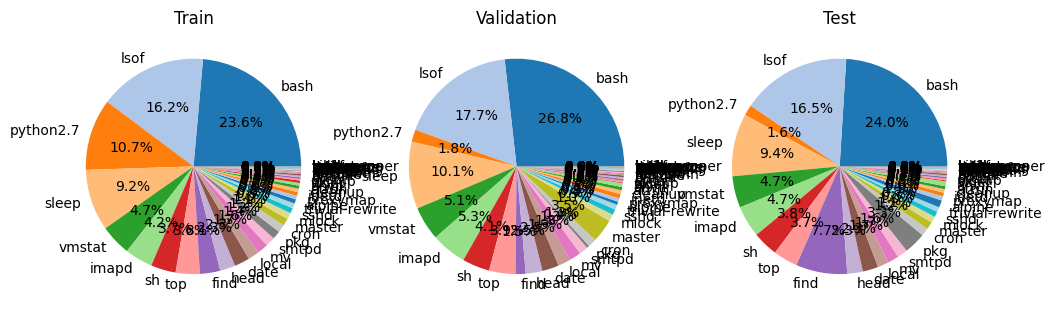

In [10]:
# print distributions in all 3 sets
train_distribution = Counter(y_train)
val_distribution = Counter(y_val)
test_distribution = Counter(y_test)

# plot 3 pie plots, use same colors for same classes
colors = plt.cm.tab20.colors
colors = [ colors[i % 20] for i in range(labels_cardinality) ]

# sort labels by occurence in training set
sorted_labels = sorted(train_distribution, key=train_distribution.get, reverse=True)

# sort all distributions by sorted_labels
train_distribution = [train_distribution[label] for label in sorted_labels]
val_distribution = [val_distribution[label] for label in sorted_labels]
test_distribution = [test_distribution[label] for label in sorted_labels]

# transform labels to names
sorted_labels = [labels_map[label] for label in sorted_labels]

fig, axs = plt.subplots(1, 3, figsize=(30*cm, 10*cm))
axs[0].pie(train_distribution, labels=sorted_labels, colors=colors, autopct='%1.1f%%')
axs[0].set_title('Train')
axs[1].pie(val_distribution, labels=sorted_labels, colors=colors, autopct='%1.1f%%')
axs[1].set_title('Validation')
axs[2].pie(test_distribution, labels=sorted_labels, colors=colors, autopct='%1.1f%%')
axs[2].set_title('Test')
plt.savefig(f'{checkpoint_path}/distributions.png')
plt.show()

In [11]:
# one-hot encode labels
y_train = np.eye(labels_cardinality)[y_train]
y_val = np.eye(labels_cardinality)[y_val]
y_test = np.eye(labels_cardinality)[y_test]

In [14]:
# Precompute identity matrices
event_eye = np.eye(event_types_cardinality)
user_eye = np.eye(users_cardinality)
addr_eye = np.eye(addr_cardinality)
port_eye = np.eye(port_cardinality)

def encode_features(sequence: np.ndarray) -> np.ndarray:
    # Initialize the output array with precomputed shapes
    encoded_seq = np.empty((len(sequence),
        event_eye.shape[1]
        + user_eye.shape[1]
        + addr_cardinality * 4
        + port_cardinality * 4
        + 48 * 2 # 48 is latent space dimension
        + 1 # size
    ))

    for i, feature_vector in enumerate(sequence):
        # one-hot
        event = event_eye[int(feature_vector[0])]
        username = user_eye[int(feature_vector[1])]
        pred_obj1_localip = addr_eye[int(feature_vector[2])]
        pred_obj1_localport = port_eye[int(feature_vector[3])]
        pred_obj1_remoteip = addr_eye[int(feature_vector[4])]
        pred_obj1_remoteport = port_eye[int(feature_vector[5])]
        pred_obj2_localip = addr_eye[int(feature_vector[6])]
        pred_obj2_localport = port_eye[int(feature_vector[7])]
        pred_obj2_remoteip = addr_eye[int(feature_vector[8])]
        pred_obj2_remoteport = port_eye[int(feature_vector[9])]
        size = feature_vector[10]
        path1 = feature_vector[10:10+48]
        path2 = feature_vector[10+48:10+48+48]

        # Concatenate all features into a single feature vector
        encoded_seq[i] = np.concatenate((event, username, pred_obj1_localip, pred_obj1_localport, pred_obj1_remoteip, pred_obj1_remoteport, pred_obj2_localip, pred_obj2_localport, pred_obj2_remoteip, pred_obj2_remoteport, [size], path1, path2))

    return encoded_seq

X_train = [ encode_features(x) for x in X_train ]
X_val = [ encode_features(x) for x in X_val ]
X_test = [ encode_features(x) for x in X_test ]

In [15]:
feature_vector_cardinality = X_train[0].shape[1]

print(f'Feature vector cardinality: {feature_vector_cardinality}')

Feature vector cardinality: 194


In [17]:
X_train, y_train = shuffle(X_train, y_train)
X_val, y_val = shuffle(X_val, y_val)
X_test, y_test = shuffle(X_test, y_test)

build model

In [18]:
model = Sequential(layers=[
    Input(shape=(None, feature_vector_cardinality)),
    LSTM(750, return_sequences=True, recurrent_dropout=0.05),
    LSTM(750, return_sequences=True, recurrent_dropout=0.05),
    LSTM(750, return_sequences=True, recurrent_dropout=0.05),
    LSTM(750, return_sequences=True, recurrent_dropout=0.05),
    LSTM(750, return_sequences=False, recurrent_dropout=0.05),
    Dense(labels_cardinality, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 750)      │     2,835,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 750)      │     4,503,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, None, 750)      │     4,503,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, None, 750)      │     4,503,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 750)            │     4,503,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 67)             │        50,317 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,897,317 (79.72 MB)

 Trainable params: 20,897,317 (79.72 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=11,
        verbose=1,
        mode='auto',
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath=model_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1,
        mode='auto',
        min_lr=1e-8
    ),
    CSVLogger(
        filename=log_path,
        append=True
    )
]

loss = CategoricalCrossentropy()
optimizer = Adam(learning_rate=0.0001)

# class weights
y_train_int = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weights_dict = dict(enumerate(class_weights))

metrics = [
    CategoricalAccuracy(name='categorical_accuracy'),
    TopKCategoricalAccuracy(k=top_k, name=f'top_{top_k}_categorical_accuracy'),
]

weighted_metrics = [
    CategoricalAccuracy(name='w_categorical_accuracy'),
    TopKCategoricalAccuracy(k=top_k, name=f'w_top_{top_k}_categorical_accuracy'),
]

# 'categorical_focal_crossentropy'
# 'categorical_crossentropy'
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics,
    weighted_metrics=weighted_metrics,
)

train model

In [20]:
history = model.fit(
    x=Generator(X_train, y_train, 128, max_sequence_length),
    validation_data=Generator(X_val, y_val, 128, max_sequence_length),
    epochs=200,
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=2
)

# save history to file
with open(history_path, 'wb') as f:
    np.save(f, history.history)

Epoch 1/200



Epoch 1: val_loss improved from inf to 1.92335, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1109s - 574ms/step - categorical_accuracy: 0.4346 - loss: 2.9106 - top_3_categorical_accuracy: 0.6254 - w_categorical_accuracy: 0.2456 - w_top_3_categorical_accuracy: 0.4106 - val_categorical_accuracy: 0.3928 - val_loss: 1.9234 - val_top_3_categorical_accuracy: 0.7116 - val_w_categorical_accuracy: 0.3928 - val_w_top_3_categorical_accuracy: 0.7116 - learning_rate: 1.0000e-04


Epoch 2/200



Epoch 2: val_loss improved from 1.92335 to 1.60832, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1103s - 571ms/step - categorical_accuracy: 0.5901 - loss: 2.1522 - top_3_categorical_accuracy: 0.8005 - w_categorical_accuracy: 0.3910 - w_top_3_categorical_accuracy: 0.6079 - val_categorical_accuracy: 0.6926 - val_loss: 1.6083 - val_top_3_categorical_accuracy: 0.8619 - val_w_categorical_accuracy: 0.6926 - val_w_top_3_categorical_accuracy: 0.8619 - learning_rate: 1.0000e-04


Epoch 3/200



Epoch 3: val_loss did not improve from 1.60832


1932/1932 - 1101s - 570ms/step - categorical_accuracy: 0.6550 - loss: 1.7574 - top_3_categorical_accuracy: 0.8320 - w_categorical_accuracy: 0.4814 - w_top_3_categorical_accuracy: 0.6982 - val_categorical_accuracy: 0.5539 - val_loss: 1.9781 - val_top_3_categorical_accuracy: 0.7439 - val_w_categorical_accuracy: 0.5539 - val_w_top_3_categorical_accuracy: 0.7439 - learning_rate: 1.0000e-04


Epoch 4/200



Epoch 4: val_loss improved from 1.60832 to 1.33167, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1103s - 571ms/step - categorical_accuracy: 0.7136 - loss: 1.6075 - top_3_categorical_accuracy: 0.8779 - w_categorical_accuracy: 0.5193 - w_top_3_categorical_accuracy: 0.7351 - val_categorical_accuracy: 0.6939 - val_loss: 1.3317 - val_top_3_categorical_accuracy: 0.8706 - val_w_categorical_accuracy: 0.6939 - val_w_top_3_categorical_accuracy: 0.8706 - learning_rate: 1.0000e-04


Epoch 5/200



Epoch 5: val_loss improved from 1.33167 to 1.10627, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1100s - 569ms/step - categorical_accuracy: 0.7266 - loss: 1.4192 - top_3_categorical_accuracy: 0.8851 - w_categorical_accuracy: 0.5668 - w_top_3_categorical_accuracy: 0.7632 - val_categorical_accuracy: 0.8678 - val_loss: 1.1063 - val_top_3_categorical_accuracy: 0.9144 - val_w_categorical_accuracy: 0.8678 - val_w_top_3_categorical_accuracy: 0.9144 - learning_rate: 1.0000e-04


Epoch 6/200



Epoch 6: val_loss did not improve from 1.10627


1932/1932 - 1101s - 570ms/step - categorical_accuracy: 0.7785 - loss: 1.2346 - top_3_categorical_accuracy: 0.9193 - w_categorical_accuracy: 0.6162 - w_top_3_categorical_accuracy: 0.8061 - val_categorical_accuracy: 0.8465 - val_loss: 1.2274 - val_top_3_categorical_accuracy: 0.9154 - val_w_categorical_accuracy: 0.8465 - val_w_top_3_categorical_accuracy: 0.9154 - learning_rate: 1.0000e-04


Epoch 7/200



Epoch 7: val_loss improved from 1.10627 to 1.04458, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1103s - 571ms/step - categorical_accuracy: 0.8189 - loss: 1.1396 - top_3_categorical_accuracy: 0.9361 - w_categorical_accuracy: 0.6352 - w_top_3_categorical_accuracy: 0.8330 - val_categorical_accuracy: 0.8548 - val_loss: 1.0446 - val_top_3_categorical_accuracy: 0.9084 - val_w_categorical_accuracy: 0.8548 - val_w_top_3_categorical_accuracy: 0.9084 - learning_rate: 1.0000e-04


Epoch 8/200



Epoch 8: val_loss did not improve from 1.04458


1932/1932 - 1101s - 570ms/step - categorical_accuracy: 0.8263 - loss: 1.0661 - top_3_categorical_accuracy: 0.9459 - w_categorical_accuracy: 0.6762 - w_top_3_categorical_accuracy: 0.8440 - val_categorical_accuracy: 0.5817 - val_loss: 2.3663 - val_top_3_categorical_accuracy: 0.6526 - val_w_categorical_accuracy: 0.5817 - val_w_top_3_categorical_accuracy: 0.6526 - learning_rate: 1.0000e-04


Epoch 9/200



Epoch 9: val_loss improved from 1.04458 to 0.72427, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1105s - 572ms/step - categorical_accuracy: 0.8678 - loss: 0.8915 - top_3_categorical_accuracy: 0.9517 - w_categorical_accuracy: 0.7191 - w_top_3_categorical_accuracy: 0.8801 - val_categorical_accuracy: 0.9105 - val_loss: 0.7243 - val_top_3_categorical_accuracy: 0.9401 - val_w_categorical_accuracy: 0.9105 - val_w_top_3_categorical_accuracy: 0.9401 - learning_rate: 1.0000e-04


Epoch 10/200



Epoch 10: val_loss improved from 0.72427 to 0.63391, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1105s - 572ms/step - categorical_accuracy: 0.8975 - loss: 0.7545 - top_3_categorical_accuracy: 0.9693 - w_categorical_accuracy: 0.7732 - w_top_3_categorical_accuracy: 0.9018 - val_categorical_accuracy: 0.9134 - val_loss: 0.6339 - val_top_3_categorical_accuracy: 0.9374 - val_w_categorical_accuracy: 0.9134 - val_w_top_3_categorical_accuracy: 0.9374 - learning_rate: 1.0000e-04


Epoch 11/200



Epoch 11: val_loss did not improve from 0.63391


1932/1932 - 1100s - 569ms/step - categorical_accuracy: 0.9004 - loss: 0.7248 - top_3_categorical_accuracy: 0.9671 - w_categorical_accuracy: 0.7791 - w_top_3_categorical_accuracy: 0.8991 - val_categorical_accuracy: 0.9086 - val_loss: 0.7718 - val_top_3_categorical_accuracy: 0.9277 - val_w_categorical_accuracy: 0.9086 - val_w_top_3_categorical_accuracy: 0.9277 - learning_rate: 1.0000e-04


Epoch 12/200



Epoch 12: val_loss did not improve from 0.63391


1932/1932 - 1101s - 570ms/step - categorical_accuracy: 0.9177 - loss: 0.6134 - top_3_categorical_accuracy: 0.9703 - w_categorical_accuracy: 0.8037 - w_top_3_categorical_accuracy: 0.9275 - val_categorical_accuracy: 0.9172 - val_loss: 0.6981 - val_top_3_categorical_accuracy: 0.9387 - val_w_categorical_accuracy: 0.9172 - val_w_top_3_categorical_accuracy: 0.9387 - learning_rate: 1.0000e-04


Epoch 13/200



Epoch 13: val_loss did not improve from 0.63391



Epoch 13: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


1932/1932 - 1101s - 570ms/step - categorical_accuracy: 0.9393 - loss: 0.5924 - top_3_categorical_accuracy: 0.9737 - w_categorical_accuracy: 0.8010 - w_top_3_categorical_accuracy: 0.9278 - val_categorical_accuracy: 0.9231 - val_loss: 0.6752 - val_top_3_categorical_accuracy: 0.9390 - val_w_categorical_accuracy: 0.9231 - val_w_top_3_categorical_accuracy: 0.9390 - learning_rate: 1.0000e-04


Epoch 14/200



Epoch 14: val_loss did not improve from 0.63391


1932/1932 - 1104s - 571ms/step - categorical_accuracy: 0.9484 - loss: 0.4068 - top_3_categorical_accuracy: 0.9711 - w_categorical_accuracy: 0.8611 - w_top_3_categorical_accuracy: 0.9565 - val_categorical_accuracy: 0.9245 - val_loss: 0.6341 - val_top_3_categorical_accuracy: 0.9390 - val_w_categorical_accuracy: 0.9245 - val_w_top_3_categorical_accuracy: 0.9390 - learning_rate: 5.0000e-05


Epoch 15/200



Epoch 15: val_loss did not improve from 0.63391


1932/1932 - 1105s - 572ms/step - categorical_accuracy: 0.9610 - loss: 0.3641 - top_3_categorical_accuracy: 0.9833 - w_categorical_accuracy: 0.8722 - w_top_3_categorical_accuracy: 0.9653 - val_categorical_accuracy: 0.9198 - val_loss: 0.6588 - val_top_3_categorical_accuracy: 0.9463 - val_w_categorical_accuracy: 0.9198 - val_w_top_3_categorical_accuracy: 0.9463 - learning_rate: 5.0000e-05


Epoch 16/200



Epoch 16: val_loss did not improve from 0.63391



Epoch 16: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


1932/1932 - 1102s - 570ms/step - categorical_accuracy: 0.9603 - loss: 0.3754 - top_3_categorical_accuracy: 0.9818 - w_categorical_accuracy: 0.8674 - w_top_3_categorical_accuracy: 0.9612 - val_categorical_accuracy: 0.9214 - val_loss: 0.6559 - val_top_3_categorical_accuracy: 0.9438 - val_w_categorical_accuracy: 0.9214 - val_w_top_3_categorical_accuracy: 0.9438 - learning_rate: 5.0000e-05


Epoch 17/200



Epoch 17: val_loss improved from 0.63391 to 0.62139, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1102s - 571ms/step - categorical_accuracy: 0.9689 - loss: 0.2848 - top_3_categorical_accuracy: 0.9858 - w_categorical_accuracy: 0.8960 - w_top_3_categorical_accuracy: 0.9748 - val_categorical_accuracy: 0.9319 - val_loss: 0.6214 - val_top_3_categorical_accuracy: 0.9465 - val_w_categorical_accuracy: 0.9319 - val_w_top_3_categorical_accuracy: 0.9465 - learning_rate: 2.5000e-05


Epoch 18/200



Epoch 18: val_loss did not improve from 0.62139


1932/1932 - 1102s - 570ms/step - categorical_accuracy: 0.9712 - loss: 0.2725 - top_3_categorical_accuracy: 0.9858 - w_categorical_accuracy: 0.9005 - w_top_3_categorical_accuracy: 0.9758 - val_categorical_accuracy: 0.9291 - val_loss: 0.6522 - val_top_3_categorical_accuracy: 0.9411 - val_w_categorical_accuracy: 0.9291 - val_w_top_3_categorical_accuracy: 0.9411 - learning_rate: 2.5000e-05


Epoch 19/200



Epoch 19: val_loss did not improve from 0.62139


1932/1932 - 1100s - 569ms/step - categorical_accuracy: 0.9724 - loss: 0.2618 - top_3_categorical_accuracy: 0.9863 - w_categorical_accuracy: 0.8987 - w_top_3_categorical_accuracy: 0.9747 - val_categorical_accuracy: 0.9338 - val_loss: 0.6332 - val_top_3_categorical_accuracy: 0.9463 - val_w_categorical_accuracy: 0.9338 - val_w_top_3_categorical_accuracy: 0.9463 - learning_rate: 2.5000e-05


Epoch 20/200



Epoch 20: val_loss did not improve from 0.62139



Epoch 20: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.


1932/1932 - 1103s - 571ms/step - categorical_accuracy: 0.9734 - loss: 0.2554 - top_3_categorical_accuracy: 0.9876 - w_categorical_accuracy: 0.8984 - w_top_3_categorical_accuracy: 0.9776 - val_categorical_accuracy: 0.9290 - val_loss: 0.6374 - val_top_3_categorical_accuracy: 0.9495 - val_w_categorical_accuracy: 0.9290 - val_w_top_3_categorical_accuracy: 0.9495 - learning_rate: 2.5000e-05


Epoch 21/200



Epoch 21: val_loss did not improve from 0.62139


1932/1932 - 1100s - 570ms/step - categorical_accuracy: 0.9757 - loss: 0.2177 - top_3_categorical_accuracy: 0.9876 - w_categorical_accuracy: 0.9091 - w_top_3_categorical_accuracy: 0.9802 - val_categorical_accuracy: 0.9354 - val_loss: 0.6235 - val_top_3_categorical_accuracy: 0.9479 - val_w_categorical_accuracy: 0.9354 - val_w_top_3_categorical_accuracy: 0.9479 - learning_rate: 1.2500e-05


Epoch 22/200



Epoch 22: val_loss did not improve from 0.62139


1932/1932 - 1102s - 570ms/step - categorical_accuracy: 0.9768 - loss: 0.2151 - top_3_categorical_accuracy: 0.9879 - w_categorical_accuracy: 0.9158 - w_top_3_categorical_accuracy: 0.9806 - val_categorical_accuracy: 0.9356 - val_loss: 0.6248 - val_top_3_categorical_accuracy: 0.9481 - val_w_categorical_accuracy: 0.9356 - val_w_top_3_categorical_accuracy: 0.9481 - learning_rate: 1.2500e-05


Epoch 23/200



Epoch 23: val_loss did not improve from 0.62139



Epoch 23: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.


1932/1932 - 1103s - 571ms/step - categorical_accuracy: 0.9775 - loss: 0.2158 - top_3_categorical_accuracy: 0.9881 - w_categorical_accuracy: 0.9096 - w_top_3_categorical_accuracy: 0.9822 - val_categorical_accuracy: 0.9364 - val_loss: 0.6283 - val_top_3_categorical_accuracy: 0.9480 - val_w_categorical_accuracy: 0.9364 - val_w_top_3_categorical_accuracy: 0.9480 - learning_rate: 1.2500e-05


Epoch 24/200



Epoch 24: val_loss did not improve from 0.62139


1932/1932 - 1104s - 571ms/step - categorical_accuracy: 0.9764 - loss: 0.1885 - top_3_categorical_accuracy: 0.9883 - w_categorical_accuracy: 0.9205 - w_top_3_categorical_accuracy: 0.9824 - val_categorical_accuracy: 0.9366 - val_loss: 0.6380 - val_top_3_categorical_accuracy: 0.9482 - val_w_categorical_accuracy: 0.9366 - val_w_top_3_categorical_accuracy: 0.9482 - learning_rate: 6.2500e-06


Epoch 25/200



Epoch 25: val_loss did not improve from 0.62139


1932/1932 - 1100s - 569ms/step - categorical_accuracy: 0.9771 - loss: 0.1869 - top_3_categorical_accuracy: 0.9884 - w_categorical_accuracy: 0.9237 - w_top_3_categorical_accuracy: 0.9836 - val_categorical_accuracy: 0.9393 - val_loss: 0.6234 - val_top_3_categorical_accuracy: 0.9484 - val_w_categorical_accuracy: 0.9393 - val_w_top_3_categorical_accuracy: 0.9484 - learning_rate: 6.2500e-06


Epoch 26/200



Epoch 26: val_loss improved from 0.62139 to 0.58510, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1102s - 570ms/step - categorical_accuracy: 0.9783 - loss: 0.1809 - top_3_categorical_accuracy: 0.9885 - w_categorical_accuracy: 0.9269 - w_top_3_categorical_accuracy: 0.9828 - val_categorical_accuracy: 0.9387 - val_loss: 0.5851 - val_top_3_categorical_accuracy: 0.9485 - val_w_categorical_accuracy: 0.9387 - val_w_top_3_categorical_accuracy: 0.9485 - learning_rate: 6.2500e-06


Epoch 27/200



Epoch 27: val_loss did not improve from 0.58510


1932/1932 - 1102s - 571ms/step - categorical_accuracy: 0.9775 - loss: 0.1780 - top_3_categorical_accuracy: 0.9884 - w_categorical_accuracy: 0.9234 - w_top_3_categorical_accuracy: 0.9838 - val_categorical_accuracy: 0.9377 - val_loss: 0.6120 - val_top_3_categorical_accuracy: 0.9483 - val_w_categorical_accuracy: 0.9377 - val_w_top_3_categorical_accuracy: 0.9483 - learning_rate: 6.2500e-06


Epoch 28/200



Epoch 28: val_loss improved from 0.58510 to 0.58188, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1103s - 571ms/step - categorical_accuracy: 0.9789 - loss: 0.1785 - top_3_categorical_accuracy: 0.9885 - w_categorical_accuracy: 0.9219 - w_top_3_categorical_accuracy: 0.9810 - val_categorical_accuracy: 0.9374 - val_loss: 0.5819 - val_top_3_categorical_accuracy: 0.9484 - val_w_categorical_accuracy: 0.9374 - val_w_top_3_categorical_accuracy: 0.9484 - learning_rate: 6.2500e-06


Epoch 29/200



Epoch 29: val_loss improved from 0.58188 to 0.57336, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1102s - 571ms/step - categorical_accuracy: 0.9782 - loss: 0.1700 - top_3_categorical_accuracy: 0.9886 - w_categorical_accuracy: 0.9247 - w_top_3_categorical_accuracy: 0.9839 - val_categorical_accuracy: 0.9390 - val_loss: 0.5734 - val_top_3_categorical_accuracy: 0.9485 - val_w_categorical_accuracy: 0.9390 - val_w_top_3_categorical_accuracy: 0.9485 - learning_rate: 6.2500e-06


Epoch 30/200



Epoch 30: val_loss improved from 0.57336 to 0.56754, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1101s - 570ms/step - categorical_accuracy: 0.9793 - loss: 0.1682 - top_3_categorical_accuracy: 0.9887 - w_categorical_accuracy: 0.9303 - w_top_3_categorical_accuracy: 0.9841 - val_categorical_accuracy: 0.9378 - val_loss: 0.5675 - val_top_3_categorical_accuracy: 0.9486 - val_w_categorical_accuracy: 0.9378 - val_w_top_3_categorical_accuracy: 0.9486 - learning_rate: 6.2500e-06


Epoch 31/200



Epoch 31: val_loss did not improve from 0.56754


1932/1932 - 1103s - 571ms/step - categorical_accuracy: 0.9792 - loss: 0.1699 - top_3_categorical_accuracy: 0.9887 - w_categorical_accuracy: 0.9250 - w_top_3_categorical_accuracy: 0.9826 - val_categorical_accuracy: 0.9393 - val_loss: 0.5760 - val_top_3_categorical_accuracy: 0.9487 - val_w_categorical_accuracy: 0.9393 - val_w_top_3_categorical_accuracy: 0.9487 - learning_rate: 6.2500e-06


Epoch 32/200



Epoch 32: val_loss did not improve from 0.56754


1932/1932 - 1102s - 571ms/step - categorical_accuracy: 0.9802 - loss: 0.1648 - top_3_categorical_accuracy: 0.9888 - w_categorical_accuracy: 0.9279 - w_top_3_categorical_accuracy: 0.9842 - val_categorical_accuracy: 0.9378 - val_loss: 0.5752 - val_top_3_categorical_accuracy: 0.9486 - val_w_categorical_accuracy: 0.9378 - val_w_top_3_categorical_accuracy: 0.9486 - learning_rate: 6.2500e-06


Epoch 33/200



Epoch 33: val_loss did not improve from 0.56754



Epoch 33: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.


1932/1932 - 1103s - 571ms/step - categorical_accuracy: 0.9785 - loss: 0.1628 - top_3_categorical_accuracy: 0.9888 - w_categorical_accuracy: 0.9270 - w_top_3_categorical_accuracy: 0.9843 - val_categorical_accuracy: 0.9411 - val_loss: 0.5748 - val_top_3_categorical_accuracy: 0.9488 - val_w_categorical_accuracy: 0.9411 - val_w_top_3_categorical_accuracy: 0.9488 - learning_rate: 6.2500e-06


Epoch 34/200



Epoch 34: val_loss improved from 0.56754 to 0.56399, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1102s - 570ms/step - categorical_accuracy: 0.9802 - loss: 0.1535 - top_3_categorical_accuracy: 0.9889 - w_categorical_accuracy: 0.9308 - w_top_3_categorical_accuracy: 0.9845 - val_categorical_accuracy: 0.9382 - val_loss: 0.5640 - val_top_3_categorical_accuracy: 0.9487 - val_w_categorical_accuracy: 0.9382 - val_w_top_3_categorical_accuracy: 0.9487 - learning_rate: 3.1250e-06


Epoch 35/200



Epoch 35: val_loss improved from 0.56399 to 0.56183, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1102s - 570ms/step - categorical_accuracy: 0.9800 - loss: 0.1506 - top_3_categorical_accuracy: 0.9889 - w_categorical_accuracy: 0.9327 - w_top_3_categorical_accuracy: 0.9845 - val_categorical_accuracy: 0.9394 - val_loss: 0.5618 - val_top_3_categorical_accuracy: 0.9488 - val_w_categorical_accuracy: 0.9394 - val_w_top_3_categorical_accuracy: 0.9488 - learning_rate: 3.1250e-06


Epoch 36/200



Epoch 36: val_loss improved from 0.56183 to 0.56051, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1105s - 572ms/step - categorical_accuracy: 0.9802 - loss: 0.1540 - top_3_categorical_accuracy: 0.9892 - w_categorical_accuracy: 0.9340 - w_top_3_categorical_accuracy: 0.9847 - val_categorical_accuracy: 0.9395 - val_loss: 0.5605 - val_top_3_categorical_accuracy: 0.9487 - val_w_categorical_accuracy: 0.9395 - val_w_top_3_categorical_accuracy: 0.9487 - learning_rate: 3.1250e-06


Epoch 37/200



Epoch 37: val_loss improved from 0.56051 to 0.55707, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1105s - 572ms/step - categorical_accuracy: 0.9809 - loss: 0.1463 - top_3_categorical_accuracy: 0.9895 - w_categorical_accuracy: 0.9360 - w_top_3_categorical_accuracy: 0.9853 - val_categorical_accuracy: 0.9396 - val_loss: 0.5571 - val_top_3_categorical_accuracy: 0.9486 - val_w_categorical_accuracy: 0.9396 - val_w_top_3_categorical_accuracy: 0.9486 - learning_rate: 3.1250e-06


Epoch 38/200



Epoch 38: val_loss did not improve from 0.55707


1932/1932 - 1099s - 569ms/step - categorical_accuracy: 0.9807 - loss: 0.1485 - top_3_categorical_accuracy: 0.9901 - w_categorical_accuracy: 0.9375 - w_top_3_categorical_accuracy: 0.9860 - val_categorical_accuracy: 0.9394 - val_loss: 0.5631 - val_top_3_categorical_accuracy: 0.9487 - val_w_categorical_accuracy: 0.9394 - val_w_top_3_categorical_accuracy: 0.9487 - learning_rate: 3.1250e-06


Epoch 39/200



Epoch 39: val_loss did not improve from 0.55707


1932/1932 - 1101s - 570ms/step - categorical_accuracy: 0.9809 - loss: 0.1468 - top_3_categorical_accuracy: 0.9903 - w_categorical_accuracy: 0.9363 - w_top_3_categorical_accuracy: 0.9864 - val_categorical_accuracy: 0.9396 - val_loss: 0.5572 - val_top_3_categorical_accuracy: 0.9523 - val_w_categorical_accuracy: 0.9396 - val_w_top_3_categorical_accuracy: 0.9523 - learning_rate: 3.1250e-06


Epoch 40/200



Epoch 40: val_loss improved from 0.55707 to 0.55431, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1103s - 571ms/step - categorical_accuracy: 0.9815 - loss: 0.1404 - top_3_categorical_accuracy: 0.9916 - w_categorical_accuracy: 0.9326 - w_top_3_categorical_accuracy: 0.9878 - val_categorical_accuracy: 0.9401 - val_loss: 0.5543 - val_top_3_categorical_accuracy: 0.9523 - val_w_categorical_accuracy: 0.9401 - val_w_top_3_categorical_accuracy: 0.9523 - learning_rate: 3.1250e-06


Epoch 41/200



Epoch 41: val_loss did not improve from 0.55431


1932/1932 - 1102s - 570ms/step - categorical_accuracy: 0.9813 - loss: 0.1409 - top_3_categorical_accuracy: 0.9925 - w_categorical_accuracy: 0.9379 - w_top_3_categorical_accuracy: 0.9888 - val_categorical_accuracy: 0.9420 - val_loss: 0.5562 - val_top_3_categorical_accuracy: 0.9540 - val_w_categorical_accuracy: 0.9420 - val_w_top_3_categorical_accuracy: 0.9540 - learning_rate: 3.1250e-06


Epoch 42/200



Epoch 42: val_loss improved from 0.55431 to 0.55323, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1103s - 571ms/step - categorical_accuracy: 0.9815 - loss: 0.1368 - top_3_categorical_accuracy: 0.9930 - w_categorical_accuracy: 0.9433 - w_top_3_categorical_accuracy: 0.9896 - val_categorical_accuracy: 0.9399 - val_loss: 0.5532 - val_top_3_categorical_accuracy: 0.9539 - val_w_categorical_accuracy: 0.9399 - val_w_top_3_categorical_accuracy: 0.9539 - learning_rate: 3.1250e-06


Epoch 43/200



Epoch 43: val_loss did not improve from 0.55323


1932/1932 - 1099s - 569ms/step - categorical_accuracy: 0.9815 - loss: 0.1428 - top_3_categorical_accuracy: 0.9935 - w_categorical_accuracy: 0.9375 - w_top_3_categorical_accuracy: 0.9905 - val_categorical_accuracy: 0.9399 - val_loss: 0.5603 - val_top_3_categorical_accuracy: 0.9540 - val_w_categorical_accuracy: 0.9399 - val_w_top_3_categorical_accuracy: 0.9540 - learning_rate: 3.1250e-06


Epoch 44/200



Epoch 44: val_loss did not improve from 0.55323


1932/1932 - 1102s - 570ms/step - categorical_accuracy: 0.9806 - loss: 0.1348 - top_3_categorical_accuracy: 0.9937 - w_categorical_accuracy: 0.9430 - w_top_3_categorical_accuracy: 0.9908 - val_categorical_accuracy: 0.9402 - val_loss: 0.5542 - val_top_3_categorical_accuracy: 0.9540 - val_w_categorical_accuracy: 0.9402 - val_w_top_3_categorical_accuracy: 0.9540 - learning_rate: 3.1250e-06


Epoch 45/200



Epoch 45: val_loss did not improve from 0.55323



Epoch 45: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.


1932/1932 - 1101s - 570ms/step - categorical_accuracy: 0.9812 - loss: 0.1341 - top_3_categorical_accuracy: 0.9938 - w_categorical_accuracy: 0.9375 - w_top_3_categorical_accuracy: 0.9909 - val_categorical_accuracy: 0.9400 - val_loss: 0.5563 - val_top_3_categorical_accuracy: 0.9540 - val_w_categorical_accuracy: 0.9400 - val_w_top_3_categorical_accuracy: 0.9540 - learning_rate: 3.1250e-06


Epoch 46/200



Epoch 46: val_loss improved from 0.55323 to 0.55252, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1103s - 571ms/step - categorical_accuracy: 0.9816 - loss: 0.1290 - top_3_categorical_accuracy: 0.9938 - w_categorical_accuracy: 0.9435 - w_top_3_categorical_accuracy: 0.9909 - val_categorical_accuracy: 0.9405 - val_loss: 0.5525 - val_top_3_categorical_accuracy: 0.9541 - val_w_categorical_accuracy: 0.9405 - val_w_top_3_categorical_accuracy: 0.9541 - learning_rate: 1.5625e-06


Epoch 47/200



Epoch 47: val_loss did not improve from 0.55252


1932/1932 - 1102s - 571ms/step - categorical_accuracy: 0.9818 - loss: 0.1279 - top_3_categorical_accuracy: 0.9938 - w_categorical_accuracy: 0.9434 - w_top_3_categorical_accuracy: 0.9909 - val_categorical_accuracy: 0.9404 - val_loss: 0.5537 - val_top_3_categorical_accuracy: 0.9541 - val_w_categorical_accuracy: 0.9404 - val_w_top_3_categorical_accuracy: 0.9541 - learning_rate: 1.5625e-06


Epoch 48/200



Epoch 48: val_loss improved from 0.55252 to 0.55189, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1103s - 571ms/step - categorical_accuracy: 0.9811 - loss: 0.1280 - top_3_categorical_accuracy: 0.9938 - w_categorical_accuracy: 0.9434 - w_top_3_categorical_accuracy: 0.9910 - val_categorical_accuracy: 0.9401 - val_loss: 0.5519 - val_top_3_categorical_accuracy: 0.9541 - val_w_categorical_accuracy: 0.9401 - val_w_top_3_categorical_accuracy: 0.9541 - learning_rate: 1.5625e-06


Epoch 49/200



Epoch 49: val_loss improved from 0.55189 to 0.55159, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1103s - 571ms/step - categorical_accuracy: 0.9816 - loss: 0.1305 - top_3_categorical_accuracy: 0.9938 - w_categorical_accuracy: 0.9369 - w_top_3_categorical_accuracy: 0.9910 - val_categorical_accuracy: 0.9401 - val_loss: 0.5516 - val_top_3_categorical_accuracy: 0.9541 - val_w_categorical_accuracy: 0.9401 - val_w_top_3_categorical_accuracy: 0.9541 - learning_rate: 1.5625e-06


Epoch 50/200



Epoch 50: val_loss improved from 0.55159 to 0.54967, saving model to saves/pioneer_4.4/model.keras


1932/1932 - 1102s - 570ms/step - categorical_accuracy: 0.9817 - loss: 0.1264 - top_3_categorical_accuracy: 0.9938 - w_categorical_accuracy: 0.9390 - w_top_3_categorical_accuracy: 0.9910 - val_categorical_accuracy: 0.9402 - val_loss: 0.5497 - val_top_3_categorical_accuracy: 0.9541 - val_w_categorical_accuracy: 0.9402 - val_w_top_3_categorical_accuracy: 0.9541 - learning_rate: 1.5625e-06


Epoch 51/200



Epoch 51: val_loss did not improve from 0.54967


1932/1932 - 1102s - 570ms/step - categorical_accuracy: 0.9814 - loss: 0.1247 - top_3_categorical_accuracy: 0.9938 - w_categorical_accuracy: 0.9438 - w_top_3_categorical_accuracy: 0.9909 - val_categorical_accuracy: 0.9402 - val_loss: 0.5531 - val_top_3_categorical_accuracy: 0.9541 - val_w_categorical_accuracy: 0.9402 - val_w_top_3_categorical_accuracy: 0.9541 - learning_rate: 1.5625e-06


Epoch 52/200



Epoch 52: val_loss did not improve from 0.54967


1932/1932 - 1103s - 571ms/step - categorical_accuracy: 0.9813 - loss: 0.1239 - top_3_categorical_accuracy: 0.9938 - w_categorical_accuracy: 0.9420 - w_top_3_categorical_accuracy: 0.9910 - val_categorical_accuracy: 0.9408 - val_loss: 0.5506 - val_top_3_categorical_accuracy: 0.9543 - val_w_categorical_accuracy: 0.9408 - val_w_top_3_categorical_accuracy: 0.9543 - learning_rate: 1.5625e-06


Epoch 53/200



Epoch 53: val_loss did not improve from 0.54967



Epoch 53: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.


1932/1932 - 1100s - 570ms/step - categorical_accuracy: 0.9816 - loss: 0.1287 - top_3_categorical_accuracy: 0.9939 - w_categorical_accuracy: 0.9412 - w_top_3_categorical_accuracy: 0.9911 - val_categorical_accuracy: 0.9406 - val_loss: 0.5526 - val_top_3_categorical_accuracy: 0.9542 - val_w_categorical_accuracy: 0.9406 - val_w_top_3_categorical_accuracy: 0.9542 - learning_rate: 1.5625e-06


Epoch 54/200



Epoch 54: val_loss did not improve from 0.54967


1932/1932 - 1101s - 570ms/step - categorical_accuracy: 0.9817 - loss: 0.1220 - top_3_categorical_accuracy: 0.9939 - w_categorical_accuracy: 0.9427 - w_top_3_categorical_accuracy: 0.9911 - val_categorical_accuracy: 0.9402 - val_loss: 0.5516 - val_top_3_categorical_accuracy: 0.9543 - val_w_categorical_accuracy: 0.9402 - val_w_top_3_categorical_accuracy: 0.9543 - learning_rate: 7.8125e-07


Epoch 55/200



Epoch 55: val_loss did not improve from 0.54967


1932/1932 - 1104s - 571ms/step - categorical_accuracy: 0.9818 - loss: 0.1232 - top_3_categorical_accuracy: 0.9939 - w_categorical_accuracy: 0.9418 - w_top_3_categorical_accuracy: 0.9911 - val_categorical_accuracy: 0.9405 - val_loss: 0.5508 - val_top_3_categorical_accuracy: 0.9543 - val_w_categorical_accuracy: 0.9405 - val_w_top_3_categorical_accuracy: 0.9543 - learning_rate: 7.8125e-07


Epoch 56/200



Epoch 56: val_loss did not improve from 0.54967



Epoch 56: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.


1932/1932 - 1102s - 570ms/step - categorical_accuracy: 0.9816 - loss: 0.1276 - top_3_categorical_accuracy: 0.9939 - w_categorical_accuracy: 0.9411 - w_top_3_categorical_accuracy: 0.9911 - val_categorical_accuracy: 0.9403 - val_loss: 0.5508 - val_top_3_categorical_accuracy: 0.9542 - val_w_categorical_accuracy: 0.9403 - val_w_top_3_categorical_accuracy: 0.9542 - learning_rate: 7.8125e-07


Epoch 57/200



Epoch 57: val_loss did not improve from 0.54967


1932/1932 - 1100s - 570ms/step - categorical_accuracy: 0.9813 - loss: 0.1256 - top_3_categorical_accuracy: 0.9939 - w_categorical_accuracy: 0.9420 - w_top_3_categorical_accuracy: 0.9910 - val_categorical_accuracy: 0.9402 - val_loss: 0.5505 - val_top_3_categorical_accuracy: 0.9542 - val_w_categorical_accuracy: 0.9402 - val_w_top_3_categorical_accuracy: 0.9542 - learning_rate: 3.9062e-07


Epoch 58/200



Epoch 58: val_loss did not improve from 0.54967


1932/1932 - 1103s - 571ms/step - categorical_accuracy: 0.9811 - loss: 0.1200 - top_3_categorical_accuracy: 0.9939 - w_categorical_accuracy: 0.9434 - w_top_3_categorical_accuracy: 0.9911 - val_categorical_accuracy: 0.9402 - val_loss: 0.5509 - val_top_3_categorical_accuracy: 0.9542 - val_w_categorical_accuracy: 0.9402 - val_w_top_3_categorical_accuracy: 0.9542 - learning_rate: 3.9062e-07


Epoch 59/200



Epoch 59: val_loss did not improve from 0.54967



Epoch 59: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.


1932/1932 - 1103s - 571ms/step - categorical_accuracy: 0.9812 - loss: 0.1207 - top_3_categorical_accuracy: 0.9939 - w_categorical_accuracy: 0.9437 - w_top_3_categorical_accuracy: 0.9911 - val_categorical_accuracy: 0.9402 - val_loss: 0.5501 - val_top_3_categorical_accuracy: 0.9542 - val_w_categorical_accuracy: 0.9402 - val_w_top_3_categorical_accuracy: 0.9542 - learning_rate: 3.9062e-07


Epoch 60/200



Epoch 60: val_loss did not improve from 0.54967


1932/1932 - 1101s - 570ms/step - categorical_accuracy: 0.9815 - loss: 0.1200 - top_3_categorical_accuracy: 0.9939 - w_categorical_accuracy: 0.9412 - w_top_3_categorical_accuracy: 0.9911 - val_categorical_accuracy: 0.9403 - val_loss: 0.5505 - val_top_3_categorical_accuracy: 0.9543 - val_w_categorical_accuracy: 0.9403 - val_w_top_3_categorical_accuracy: 0.9543 - learning_rate: 1.9531e-07


Epoch 61/200



Epoch 61: val_loss did not improve from 0.54967


1932/1932 - 1104s - 571ms/step - categorical_accuracy: 0.9816 - loss: 0.1207 - top_3_categorical_accuracy: 0.9939 - w_categorical_accuracy: 0.9447 - w_top_3_categorical_accuracy: 0.9911 - val_categorical_accuracy: 0.9403 - val_loss: 0.5506 - val_top_3_categorical_accuracy: 0.9543 - val_w_categorical_accuracy: 0.9403 - val_w_top_3_categorical_accuracy: 0.9543 - learning_rate: 1.9531e-07


Epoch 61: early stopping


Restoring model weights from the end of the best epoch: 50.


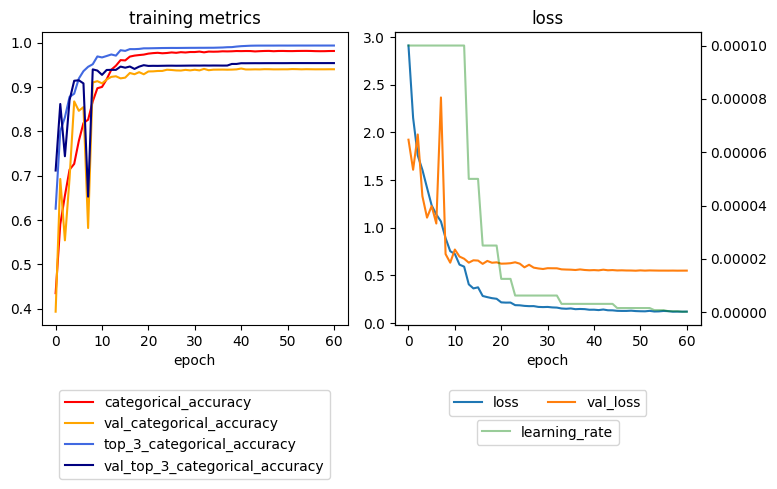

In [21]:
log = pd.read_csv(log_path)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20*cm, 15*cm))

ax1.plot(log['epoch'], log['categorical_accuracy'], label='categorical_accuracy', color='red')
ax1.plot(log['epoch'], log['val_categorical_accuracy'], label='val_categorical_accuracy', color='orange')
ax1.plot(log['epoch'], log[f'top_{top_k}_categorical_accuracy'], label=f'top_{top_k}_categorical_accuracy', color='royalblue')
ax1.plot(log['epoch'], log[f'val_top_{top_k}_categorical_accuracy'], label=f'val_top_{top_k}_categorical_accuracy', color='navy')
ax1.set_title('training metrics')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1)  # Legend below the plot

ax2.plot(log['epoch'], log['loss'], label='loss')
ax2.plot(log['epoch'], log['val_loss'], label='val_loss')
# plot learning rate with different scale, show on right side
ax2b = ax2.twinx()
ax2b.plot(log['epoch'], log['learning_rate'], label='learning_rate', color='green', alpha=.4)
ax2.set_title('loss')
ax2.set_xlabel('epoch')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)  # Legend below the plot
ax2b.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=1)  # Legend below the plot

fig.tight_layout(rect=[0, 0.1, 1, 1])

plt.savefig(f'{checkpoint_path}/metrics_loss.svg')
plt.show()

In [22]:
# load old model, if needed
try:
    model
except NameError:
    model = load_model(model_path)

In [23]:
# evaluate model
score = model.evaluate(x=Generator(X_test, y_test, 128, max_sequence_length), verbose=2)

407/407 - 75s - 184ms/step - categorical_accuracy: 0.9735 - loss: 0.1154 - top_3_categorical_accuracy: 0.9863 - w_categorical_accuracy: 0.9735 - w_top_3_categorical_accuracy: 0.9863


In [24]:
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

Test loss: 0.11537318676710129
Test accuracy: 0.9735427498817444


In [25]:
# print classification report
y_pred = model.predict(x=Generator(X_test, y_test, 128, max_sequence_length), verbose=2)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

distinct_labels = [labels_map[i] for i in range(labels_cardinality)]

report = classification_report(y_true, y_pred, target_names=distinct_labels, zero_division=np.nan)
report_dict = classification_report(y_true, y_pred, target_names=distinct_labels, zero_division=np.nan, output_dict=True)

print(report)

# save classification report to file
with open(f'{checkpoint_path}/classification_report.txt', 'w') as f:
    json.dump(report_dict, f)

407/407 - 76s - 188ms/step


                 precision    recall  f1-score   support

      adjkerntz       0.46      1.00      0.63        11
         alpine       0.96      0.99      0.98       560
          anvil       0.31      1.00      0.47       378
          atrun       1.00      1.00      1.00       237
            awk       1.00      1.00      1.00         5
       basename       1.00      1.00      1.00         2
           bash       1.00      1.00      1.00     12512
            cat       0.86      0.92      0.89        26
        cleanup       0.53      0.72      0.61       276
            cmp       1.00      1.00      1.00         5
             cp       0.94      0.97      0.95        30
           cron       1.00      1.00      1.00       624
           date       1.00      1.00      1.00      1218
             dd       0.99      0.99      0.99       125
       dhclient       0.09      0.41      0.14        17
          dmesg       1.00      1.00      1.00        15
          egrep       1.00    

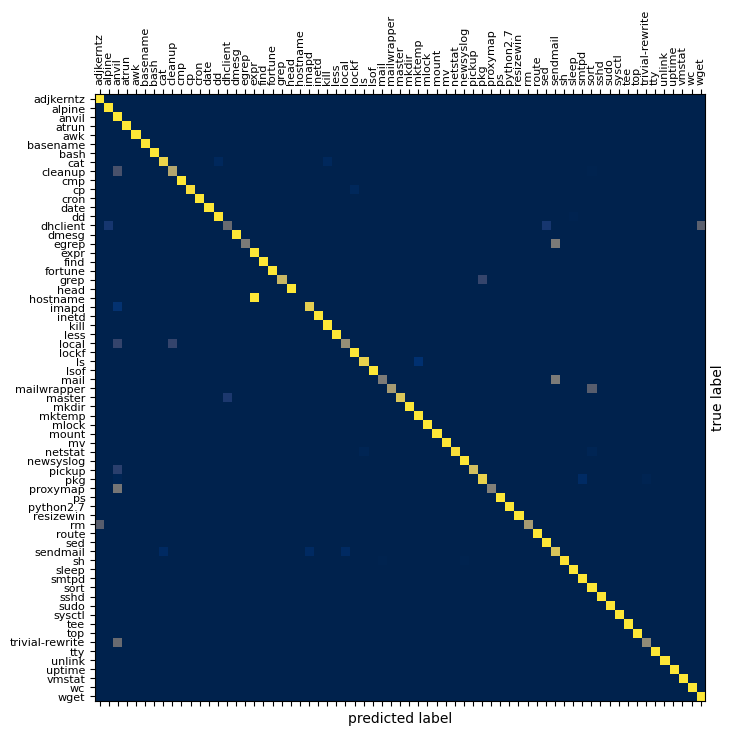

In [26]:
# print confusion matrix
# labels explicitly set, because current model may not predict all labels
conf_matrix = confusion_matrix(y_true, y_pred, labels=range(labels_cardinality), normalize='true')

# Replace all NaN values with 0
conf_matrix = np.nan_to_num(conf_matrix)

# Verify the distinct labels align correctly
distinct_labels = [labels_map[i] for i in range(labels_cardinality)]

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(20*cm, 20*cm))

ax.matshow(conf_matrix, cmap='cividis', aspect='auto')

# Set class names on axes
ax.set_xticks(range(len(distinct_labels)))
ax.set_yticks(range(len(distinct_labels)))
ax.set_xticklabels(distinct_labels, rotation=90, fontsize=8)
ax.set_yticklabels(distinct_labels, fontsize=8)

# Set axis labels "predicted" and "actual"
ax.set_xlabel('predicted label')
ax.set_ylabel('true label')
# y-axis label right side
ax.yaxis.set_label_position('right')

# set figsize
plt.savefig(f'{checkpoint_path}/confusion_matrix.svg')
plt.show()

In [27]:
unique_in_y_pred = [ labels_map[i] for i in np.unique(y_pred) ]
#print("Unique labels in y_pred:", unique_in_y_pred)

unique_not_in_y_pred = [ label for label in distinct_labels if label not in unique_in_y_pred ]
print("Unique labels not in y_pred:", unique_not_in_y_pred)

Unique labels not in y_pred: ['hostname']
